In [1]:
import pandas as pd
import torch
from src.colors import bcolors
from config import Config

c = bcolors()
config = Config()

(1764,)


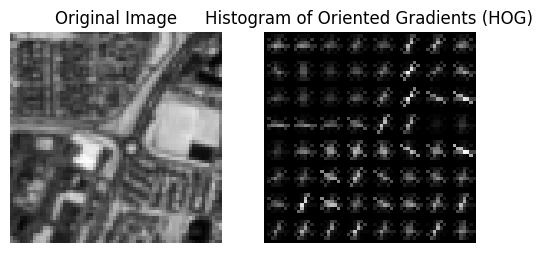

In [2]:

import rasterio
from skimage import data, exposure
from skimage import filters
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt

f_path = "../data/train/EuroSAT_MS/AnnualCrop/AnnualCrop_1.tif"
ft_path = "../data/test/NoLabel/test_54.npy"

image = np.load(ft_path).transpose(2, 0, 1)

# with rasterio.open(f_path) as src:
#     image = np.array(src.read())

rgb_min, rgb_max = image.min(), image.max()
image = (image - rgb_min) / (rgb_max - rgb_min)

chn = [7]
image = image[chn].astype(np.float32)
features, hog_image = hog(image,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualize=True,
                          feature_vector=True,
                          channel_axis=0)
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

print(features.shape)
# Plotting the original image and HOG feature image
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

ax[0].imshow(image.transpose(1, 2, 0), cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax[1].set_title('Histogram of Oriented Gradients (HOG)')
ax[1].axis('off')

plt.show()

In [3]:
from src.pickle_loader import save_object
from sklearn.preprocessing import LabelEncoder
from src.datasets.EuroSatMSFeatures import EuroSatMSFeatures

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv(config.TRAIN_FILE)

encoder = LabelEncoder()
encoder = encoder.fit(df[['label']].values.flatten())
save_object(encoder, "../data/label_encoder")

chn = [7]

dataset = EuroSatMSFeatures(df, chn, config.TRAIN_MS_DIR, encoder=encoder)



Preloading images...
Number of images: 27000
Number of jobs:   -4 


In [4]:
import numpy as np
import xgboost as xgb

feats = np.array(dataset.x_data)
labels = np.array(dataset.y_data)

print(feats.shape)
print(labels.shape)

(27000, 1764)
(27000,)


In [18]:
from skopt.space import Integer, Real, Categorical
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import numpy as np
import xgboost as xgb

skf_idx = []
skf = StratifiedKFold(n_splits=5)
for fold, (train_index, test_index) in enumerate(skf.split(feats, labels)):
    skf_idx.append((train_index, test_index))
    
model = XGBClassifier(
    nthread=-1,
    seed=27,
    device="cuda"
)

parameter_space = {
    'n_estimators': Integer(300, 500),
    'learning_rate': Real(0.0001, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 6),
    'subsample': Real(0.3, 0.7),
    'colsample_bytree': Real(0.3, 0.7),
    'booster': Categorical(['gbtree']),
    'reg_lambda': Integer(0, 10),
    'reg_alpha': Integer(0, 10),
    'gamma': Real(0.0, 0.5),
}

fit_param = {
    'early_stopping_rounds': 10,
}

In [19]:
clf = BayesSearchCV(estimator=model,
                    search_spaces=parameter_space,
                    fit_params=fit_param,
                    cv=skf_idx[:1],
                    n_iter=20,
                    scoring='accuracy',
                    verbose=4)

clf.fit(feats, y=labels)
print(clf.cv_results_)
print(clf.best_score_)
print(clf.best_params_)
results = pd.DataFrame(clf.cv_results_)
results.to_csv("results.csv")

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END booster=gbtree, colsample_bytree=0.4687765262992426, gamma=0.16026753165228172, learning_rate=0.0007727417678303601, max_depth=4, n_estimators=411, reg_alpha=5, reg_lambda=6, subsample=0.45913832631877183;, score=0.436 total time=  50.3s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END booster=gbtree, colsample_bytree=0.36413123888732274, gamma=0.09144203548913861, learning_rate=0.0055820152554823576, max_depth=4, n_estimators=485, reg_alpha=6, reg_lambda=2, subsample=0.4193052582007505;, score=0.486 total time=  56.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END booster=gbtree, colsample_bytree=0.5212656363946626, gamma=0.4707074954006231, learning_rate=0.008792634861662832, max_depth=5, n_estimators=442, reg_alpha=1, reg_lambda=5, subsample=0.47806038721637334;, score=0.524 total time= 1.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END 

In [21]:
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier
from src.datasets.EuroSatTestFeatures import EuroSatTestSetFeatures

results.to_csv("results.csv")
best_score = results['mean_test_score'].max()
best_param = results[results['mean_test_score'] == best_score]['params'].values[0]
print(best_param)
param = dict(booster="gbtree", colsample_bytree=0.3, gamma=0.5, learning_rate=0.1, max_depth=6, n_estimators=500, reg_alpha=0, reg_lambda=10, subsample=0.7)

train_index, test_index = skf_idx[0]
train_data = dataset.x_data[train_index]
train_labels = dataset.y_data[train_index]
test_data = dataset.x_data[test_index]
test_labels = dataset.y_data[test_index]

# param = {
#     'n_estimators': 500,
#     # 'learning_rate': 0.06,
#     # 'max_depth': 5,
#     # 'subsample': 0.5,
#     # 'colsample_bytree': 0.5,
#     # 'booster': 'gbtree',
#     # 'reg_lambda': 1,
#     # 'reg_alpha': 4,
#     # 'gamma': 0.3
# }

OrderedDict([('booster', 'gbtree'), ('colsample_bytree', 0.6587249892776736), ('gamma', 0.30661162970413336), ('learning_rate', 0.0873445387964865), ('max_depth', 6), ('n_estimators', 469), ('reg_alpha', 1), ('reg_lambda', 7), ('subsample', 0.5689542852799243)])


In [26]:
model = XGBClassifier(
    *best_param,
    nthread=-1,
    seed=27,
    device="cuda",
    early_stopping_rounds=100,
)

train_m = xgb.DMatrix(train_data, label=train_labels)
test_m = xgb.DMatrix(test_data, label=test_labels)

model.fit(train_m,
          eval_set=test_m)

preds = model.predict(test_data)
model.save_model("model")

/home/tobias/Desktop/Uni/SS24/ML/EuroSat_Dataset_LUC/.venv/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


TypeError: XGBClassifier.fit() missing 1 required positional argument: 'y'

In [25]:
preds = preds.flatten()
# compute accuracy
acc = np.mean(preds == test_labels)

print("Number of samples in test set: ", len(test_labels))
print("Number of samples in train set: ", len(train_labels))
print(f'Accuracy: {acc}')

Number of samples in test set:  5400
Number of samples in train set:  21600
Accuracy: 0.5753703703703704


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

model.load_model("model")

In [ ]:
from src.datasets.EuroSatTestFeatures import EuroSatTestSetFeatures
import numpy as np
from matplotlib import pyplot as plt

channels = [3, 2, 1]
test_set = EuroSatTestSetFeatures(config.TEST_MS_DIR, channels=channels)

test_feats = np.array([x[0] for x in test_set.samples])
test_ids = np.array([x[1] for x in test_set.samples])
n = 3
predictions = model.predict(test_feats)

print(np.unique(preds, return_counts=True))
pred_labels = encoder.inverse_transform(preds.astype(int))

for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(test_ids[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = test_ids[idx]
        
        im_path = f"data/test/NoLabel/test_{samp_id}.npy"
        
        
        img = np.load(im_path).transpose(2, 0, 1)
        img = img[[3, 2, 1]].astype(np.float32)

        # img = img[[-2, -3, -4]].transpose(1, 2, 0)
        
        #raw = np.load(f"data/test/NoLabel/test_{samp_id}.npy")
        #img = raw[:, :, [3, 2, 1]]

        # Normalize the image
        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min)

        # Plotting
        ax.imshow(img.transpose(1, 2, 0))
        ax.set_title(pred, fontsize=20)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

In [ ]:
sub_df = pd.DataFrame({'test_id': test_ids, 'label': pred_labels})
sub_df = sub_df.sort_values(by='test_id')
print(sub_df.head())

sub_df.to_csv('submission.csv', index=False)